# CEO-Request Challenge

## 1. Summary of Problem Statement

❓ **How could Olist improve its profit** ❓

### P&L Rules

#### Revenues  
**Sales fees:** Olist takes a **10% cut** on the product price (excl. freight) of each order delivered  
**Subscription fees:** Olist charges **80 BRL by month** per seller

#### Costs
**Reputation costs** *estimated* per order with bad reviews (<= 3 stars)  

💡 In the long term, bad customer experience has business implications: low repeat rate, immediate customer support cost, refunds or unfavorable word of mouth communication. We will assume that we have an estimate measure of the monetary cost for each bad review:
```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist's **total cumulated IT Costs** scale with the square root of the total number of sellers that has ever join the platform, as well as the square root of the total cumulated number of products that was ever sold.  

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_products}$  
Olist's data team gave us the following values for these scaling parameters:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Both number of sellers to manage and sales transaction are costly for IT systems.  
💡 Yet square roots reflect scale-effects: IT-system are often more efficient as they grow bigger.  
💡 Alpha > Beta means that "Olist has a lower IT Cost with few sellers selling a lot of products rather than the opposite  
- with **1000 sellers** and a total of **100 products** sold, the total IT cost accumulates to 109,624 BRL
- with **100 sellers** and a total of **1000 products** sold, the total IT cost accumulates to 62,507 BRL

Finally, The IT department also told you that since the birth of the marketplace, cumulated IT costs have amounted to **500,000 BRL**.

### Key Findings, so far

- `wait_time` is the most significant factor behind low review scores  
- `wait_time` is made up of seller's `delay_to_carrier` + `carrier_delivery_time`.  
- The latter being outside of Olist's direct control, improving it is not a quick-win recommendation
- On the contrary, a better selection of `sellers` can positively impact the `delay_to_carrier` and reduce the number of bad `review_scores` on Olist.
- Comments of the bad reviews showed that some were linked to the seller or to the product itself.

💡 We recommend you to start with the the guided seller analysis in part 2 below  
💪 But feel free to investigate into other hypothesis instead with part 3

## 2. Should Olist remove under-performing sellers from its marketplace? 🕵🏻
*(recommended)*

To analyze the impact of removing the worse sellers from Olist's marketplace, we will perform a **what-if analysis**

👉 **What would have happened if Olist had never accepted these sellers in the first place?**  

*(In practice, it's hard to know in advance who is a good seller, but let's start with this approach and iterate later).*

### 2.1 Data Preparation

Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `review_costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)

👉 Write down a step-by-step strategy to create the DataFrame you need


⚠️ Don't start from scratch, update your existing package 😉

Starting from the `Seller` class of your `olist` package:

Edit the `get_training_data` method so that the DataFrame it returns contains the fields:
- `revenues`: sum of subscription and sales fees revenues
- `cost_of_reviews`: sum of costs associated with bad reviews
- `profits`: `revenues` - `cost_of_reviews`

### 2.2 What-if Analysis

👉 Time to perform the actual analysis, here are our steps:  

1️⃣ Create a method that will help us update the IT Costs after removing sellers along with the products they sold

2️⃣ Sort sellers by increasing profits

3️⃣ Remove sellers one by one, starting from the one with the lowest profit.
- For each number of sellers to remove, compute the financial impact on Olist global profits.

4️⃣ Find an optimal number of sellers to remove that maximizes either Olist's profit margin or profit.

## 3. Investigate other Approaches 🕵️
*(optional)*

- Should Olist remove the worst performing products / categories from its marketplace entirely?
- Should Olist remove only consistently underperforming sellers, after it has a honeymoon period of few months?
- Should Olist restrict seller/customer pairs between certain states to avoid delays?
- Should Olist acquire new sellers, with some cost assumptions to be suggested?
- ...


## Your turn!

🧺 Keep this notebook tidy! 

🗣 📊 You will present your insights to your favorite TA at the end of this `Communicate` unit 💪

# DATA PREPERATION

## Import Packages & Data

In [1]:
# input autoreload
%load_ext autoreload
%autoreload 2

In [2]:
#import usual packages
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import math

## Check Data

In [3]:
# Import your newly coded _order_ training set
from olist.seller import Seller
from olist.order import Order
from olist.data import Olist
olist = Olist()
data = olist.get_data()

sellers = Seller().get_training_data()
orders = Order().get_training_data(with_distance_seller_customer=True)

sellers.head(2)

/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:33: SettingWi

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.050000,0.725000,4.55


## Calculate Revenue and Review Costs

In [4]:
#calculate revenue per seller
sellers['revenues'] = sellers['sales'] * 0.1 + sellers['months_on_olist'] * 80
sellers.head(2)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,share_of_one_stars,share_of_five_stars,review_score,revenues
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.0,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,1.000,218.70,0.333333,0.333333,3.00,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.0,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,1.025,11703.07,0.050000,0.725000,4.55,2290.307


In [5]:
data.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

### Import sellers and sellers items tables

In [6]:
orders_new = data['orders'].copy()
ordersitems = data['order_items'].copy()
orderreviews = data['order_reviews'].copy()


### Merge table Order and Order Items

In [7]:
combined_table = orders_new.merge(ordersitems,on='order_id').merge(orderreviews,on='order_id')
combined_table.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50


### Calculate review cost per seller

In [8]:

cost_dict ={1: 100, 2: 50, 3: 40,4: 0, 5: 0}

combined_table['cost_of_reviews'] = combined_table['review_score'].map(cost_dict)
combined_table.tail(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,...,shipping_limit_date,price,freight_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,cost_of_reviews
112370,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,2,d1c427060a0f73f6b889a5c7c61f2ac4,...,2018-01-12 21:36:21,179.99,40.59,8ab6855b9fe9b812cd03a480a25058a1,2,NaN,Foi entregue somente 1. Quero saber do outro p...,2018-01-26 00:00:00,2018-01-27 09:16:56,50
112371,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-03-08 20:57:30,2018-03-09 11:20:28,2018-03-09 22:11:59,2018-03-16 13:08:30,2018-04-03 00:00:00,1,006619bbed68b000c8ba3f8725d5409e,...,2018-03-15 10:55:42,68.50,18.36,dc9c59b4688062c25758c2be4cafc523,5,NaN,NaN,2018-03-17 00:00:00,2018-03-17 16:33:31,0


In [9]:
combined_table = combined_table.groupby('seller_id').sum()
combined_table.head(2)

,order_item_id,price,freight_value,review_score,cost_of_reviews
seller_id,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,2685.00,63.06,11,100
001cca7ae9ae17fb1caed9dfb1094831,289,24770.03,8757.89,921,4750


### Merge sellers and combined_table

In [36]:
profit = pd.merge(sellers,combined_table, left_on='seller_id', right_on='seller_id', how='left')
profit.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,sales,share_of_one_stars,share_of_five_stars,review_score_x,revenues,order_item_id,price,freight_value,review_score_y,cost_of_reviews
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,...,218.70,0.333333,0.333333,3.00,341.870,4,218.70,27.90,9,140
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,...,11703.07,0.050000,0.725000,4.55,2290.307,42,11703.07,1438.73,187,240
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,...,158.00,0.000000,1.000000,5.00,15.800,1,158.00,16.21,5,0
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,...,79.99,0.000000,1.000000,5.00,7.999,1,79.99,15.66,5,0
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,...,167.99,1.000000,0.000000,1.00,16.799,1,167.99,31.93,1,100


### Calculate profit column

In [37]:
profit["profits"] = profit["revenues"] - profit["cost_of_reviews"]
profit.head()


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_one_stars,share_of_five_stars,review_score_x,revenues,order_item_id,price,freight_value,review_score_y,cost_of_reviews,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,3,3,...,0.333333,0.333333,3.00,341.870,4,218.70,27.90,9,140,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,40,41,...,0.050000,0.725000,4.55,2290.307,42,11703.07,1438.73,187,240,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,1,1,...,0.000000,1.000000,5.00,15.800,1,158.00,16.21,5,0,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,1,1,...,0.000000,1.000000,5.00,7.999,1,79.99,15.66,5,0,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1,1,...,1.000000,0.000000,1.00,16.799,1,167.99,31.93,1,100,-83.201


# How could Olist increase its profit?

## Snapshot of current company PL in BRL

Where are we?

In [105]:



def it_cost():
#     print("It cost:")
    return round((3157.27 * math.sqrt(profit.seller_id.count())) + (978.23 * math.sqrt(profit.quantity.sum())) + 500000)

def review_cost():
#     print("Review cost")
    return profit.cost_of_reviews.sum()

def total_cost():
#     print("Total cost")
    return round((3157.27 * math.sqrt(profit.seller_id.count())) + (978.23 * math.sqrt(profit.quantity.sum())) + 500000) + profit.cost_of_reviews.sum()

def revenue():
#     print("Revenue")
    return round(profit.revenues.sum())

def net_profit():
#     print("Profit")
    
    rev = round(profit.revenues.sum())
    cos = round((3157.27 * math.sqrt(profit.seller_id.count())) + (978.23 * math.sqrt(profit.quantity.sum())) + 500000) + profit.cost_of_reviews.sum()
    
    return (rev - cos)
    


def profit_margin():
#     print("Profit_margin")
    
    rev = round(profit.revenues.sum())
    cos = round((3157.27 * math.sqrt(profit.seller_id.count())) + (978.23 * math.sqrt(profit.quantity.sum())) + 500000) + profit.cost_of_reviews.sum()
    
    return "{:.0%}".format((rev - cos) / rev)


# print(it_cost())
# print(review_cost())
# print(total_cost())
# print(revenue())
# print(net_profit())
# print(profit_margin())

f'{review_cost():,}' 

data = [[revenue(), 0], ['', review_cost()], ['', it_cost()], ['', total_cost()] , ['', net_profit()], ['', profit_margin()]]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['+', '-'])
  
# print dataframe.
df

df_new = df.rename(columns={'A': 'Col_1'}, index={0: 'Revenue (Sales and Subscription)', 1: "Reputation Cost (Review Score)", 2: "IT Cost (Fixed and Variable)", 3: "Total Cost", 4: "Net Profit (Revenue - Total Cost)", 5: "Profit Margin"})
df_new


,+,-
Revenue (Sales and Subscription),2785818,0
Reputation Cost (Review Score),,1976650
IT Cost (Fixed and Variable),,999999
Total Cost,,2976649
Net Profit (Revenue - Total Cost),,-190831
Profit Margin,,-7%


In [67]:
profit = profit.sort_values(['profits'], ascending= True)
profit.head(2)

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,...,share_of_one_stars,share_of_five_stars,review_score_x,revenues,order_item_id,price,freight_value,review_score_y,cost_of_reviews,profits
769,6560211a19b47992c3666cc44a7e94c0,sao paulo,SP,0.0,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,18.0,1854,2033,...,0.124729,0.514100,3.937093,13770.483,2244,122484.82,27826.47,7897,40120,-26349.517
453,1f50f920176fa81dab994f9023523100,sao jose do rio preto,SP,0.0,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,17.0,1404,1931,...,0.112536,0.600427,4.130342,12053.921,2902,107002.21,35152.96,7694,37490,-25436.079


## Recalculation of  profit and margin by removing sellers 

Lets remove  sellers one by one starting from the least profitable and see what happens to company profit and margins

In [81]:
finaldf = profit [["seller_id", "quantity", "revenues","cost_of_reviews","profits"]]
finaldf.reset_index(drop = True, inplace=True)
finaldf

def max_profit():
    profit_list = []

    for i in range(0,len(finaldf)):

        rev = round(finaldf.iloc[i:,:].revenues.sum())
        cos = round((3157.27 * math.sqrt(finaldf.iloc[i:,:].seller_id.count())) + (978.23 * math.sqrt(finaldf.iloc[i:,:].quantity.sum())) + 500000) + finaldf.iloc[i:,:].cost_of_reviews.sum()

        profit_list.append(rev - cos)
        
    return profit_list

def max_margin():
    margin_list = []

    for i in range(0,len(finaldf)):

        rev = round(finaldf.iloc[i:,:].revenues.sum())
        cos = round((3157.27 * math.sqrt(finaldf.iloc[i:,:].seller_id.count())) + (978.23 * math.sqrt(finaldf.iloc[i:,:].quantity.sum())) + 500000) + finaldf.iloc[i:,:].cost_of_reviews.sum()

        margin_list.append(((rev - cos) / rev))
        
    return margin_list

# len(max_margin())

#         margin_list.append("{:.2%}".format((rev - cos) / rev))

finaldf['max_margin_line'] = max_margin()
finaldf['max_profit_line'] = max_profit()
finaldf[['max_margin_line']].idxmax()

/var/folders/kg/6qqrzjg91x5d3tq16qx18m2w0000gn/T/ipykernel_33512/1479610633.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finaldf['max_margin_line'] = max_margin()
/var/folders/kg/6qqrzjg91x5d3tq16qx18m2w0000gn/T/ipykernel_33512/1479610633.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finaldf['max_profit_line'] = max_profit()


max_margin_line    1313
dtype: int64

In [ ]:
sns.lineplot(data=finaldf["max_profit_line"])


 ## Our findings in a graph
 
 We call our new profit and margin hypothetical profit and margin

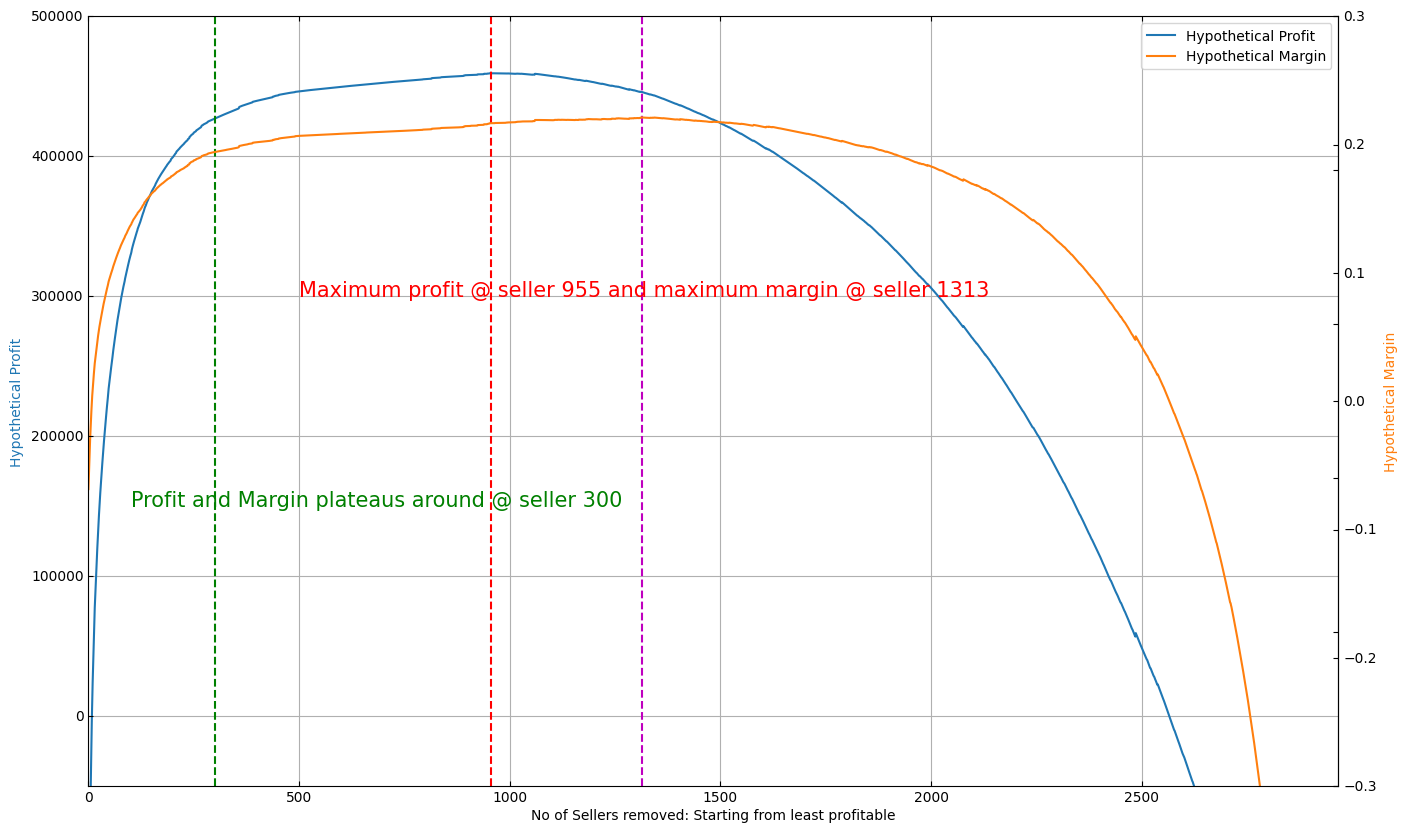

In [196]:
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt

host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)
plt.rcParams["figure.figsize"] = (20, 10) # update


par1 = host.twinx()
par2 = host.twinx()

# par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))

par1.axis["right"].toggle(all=True)
# par2.axis["right"].toggle(all=True)

p1, = host.plot(range(0,2967), finaldf["max_profit_line"], label="Hypothetical Profit")
p2, = par1.plot(range(0,2967), finaldf["max_margin_line"], label="Hypothetical Margin")
# p3, = par2.plot([0, 1, 2], [50, 30, 15], label="Velocity")


host.set_xlim(0, 2967)
host.set_ylim(-50000, 500000)
par1.set_ylim(-0.3, 0.3)
# par2.set_ylim(1, 500000)

host.set_xlabel("No of Sellers removed: Starting from least profitable")
host.set_ylabel("Hypothetical Profit")
par1.set_ylabel("Hypothetical Margin")
# par2.set_ylabel("Velocity")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
# par2.axis["right"].label.set_color(p3.get_color())


plt.axvline(x = 955, color = 'r',linestyle='dashed')
plt.axvline(x = 1313, color = 'm',linestyle='dashed')
plt.axvline(x = 300, color = 'g',linestyle='dashed')

plt.text(x = 500, y =300000, s= 'Maximum profit @ seller 955 and maximum margin @ seller 1313', fontsize = 15, color = "r")
plt.text(x = 100, y =150000, s= 'Profit and Margin plateaus around @ seller 300', fontsize = 15, color = "g" )


plt.grid(True)
plt.show()

Findings:

1 ) We reach maximum profit when we stop working with least profitable 955 sellers.


2 ) We reach maximum profit margin when we stop working with least profitable 1313 sellers.


Suggestions:

1 ) Conservative approach: stop working with least profitable 300 sellers or find ways to penalize them with additional costs. Keep other sellers as we may find ways to profit from them. Also we don't want to decrease order volume.

2 ) Between seller 955 and 1313 revenues drop faster than profit which increases profit margins


 ## Properties of sellers (Worst 300 versus Best 300)

In [226]:
badsellers = profit [["seller_id", "seller_city", "wait_time","months_on_olist","review_score_x" ,'freight_value','profits']]
badsellers.head(300).mean()

/var/folders/kg/6qqrzjg91x5d3tq16qx18m2w0000gn/T/ipykernel_33512/3543090869.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  badsellers.head(300).mean()


wait_time            14.429755
months_on_olist       8.723333
review_score_x        3.437748
freight_value      3050.976000
profits           -1739.931723
dtype: float64

In [227]:
badsellers.tail(300).mean()

/var/folders/kg/6qqrzjg91x5d3tq16qx18m2w0000gn/T/ipykernel_33512/2688783044.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  badsellers.tail(300).mean()


wait_time            12.726909
months_on_olist      14.786667
review_score_x        4.218829
freight_value      1809.979367
profits            2040.269977
dtype: float64

Findings:

1 ) Bad sellers have longer average wait time.

2 ) Bad sellers are recently listed on Olist compared to best sellers.

3 ) Bad sellers have lower average review score

4 ) Average freight value tends to be higher for bad sellers.


Suggestions:

1 ) Introduce additional fee based on wait time to penalize bad sellers.

2 ) Be more selective with new listings.

3 ) Introduce additional fee based on review score to penalize bad sellers.

 

### Worst 300 sellers by their location

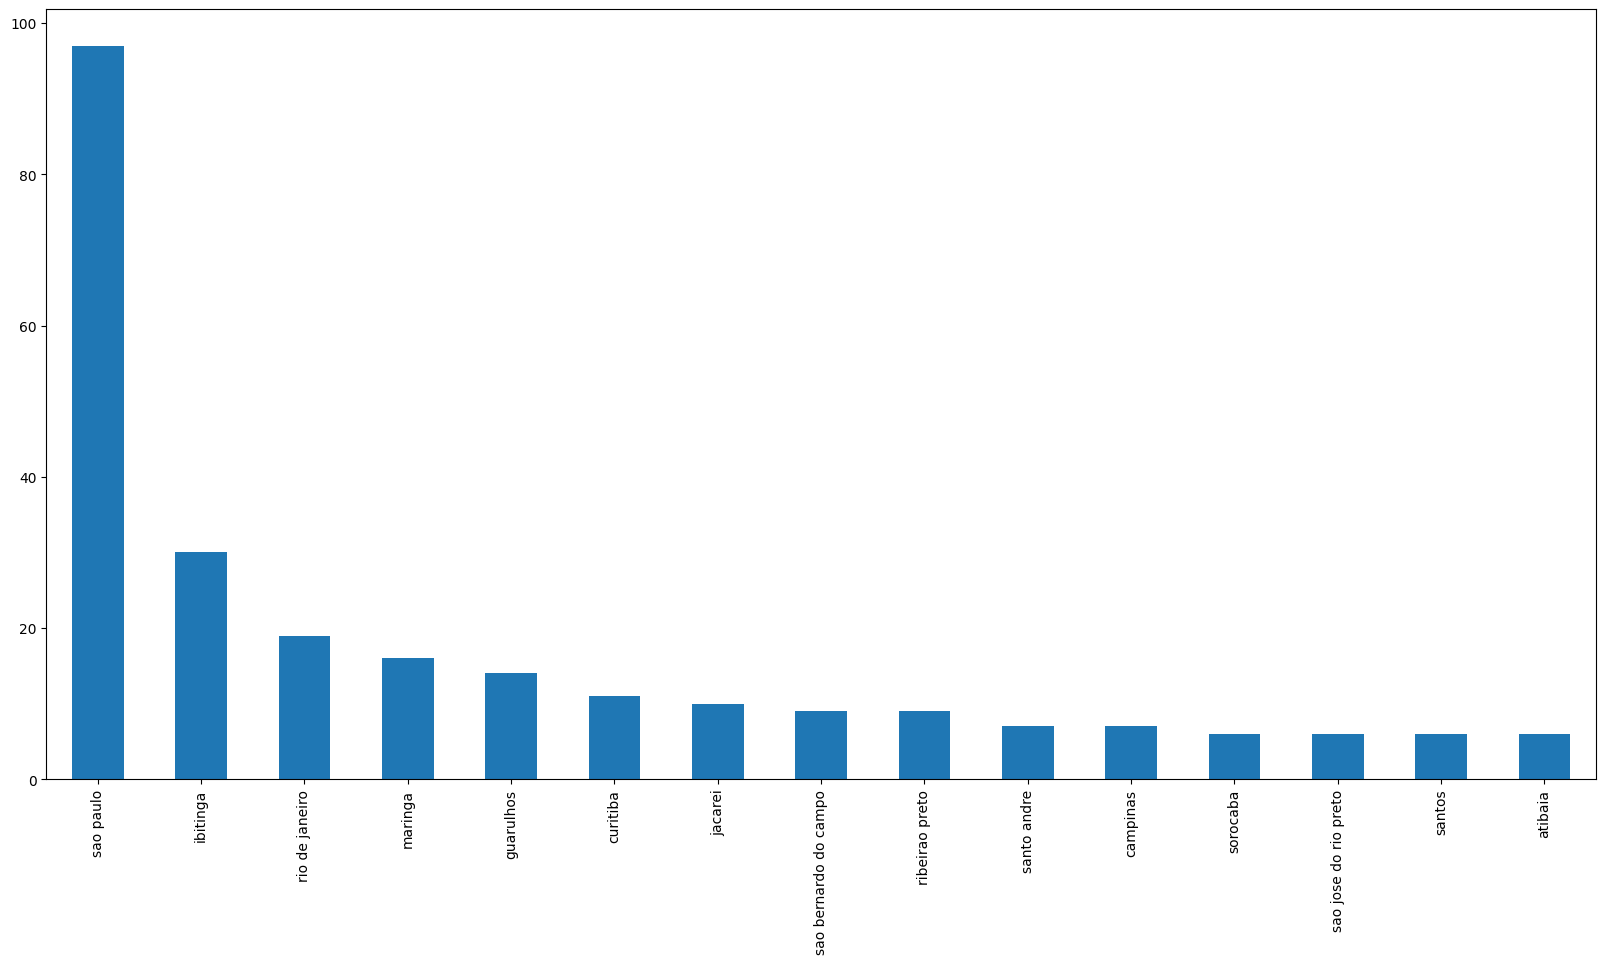

In [250]:
# # df = badsellers.head(500).groupby(['seller_city']).count() 
# df = badsellers.tail(500).sort_values(['profits'], ascending= True)

# sns.countplot(y='seller_city', data=df)

import string

l = list(badsellers.head(300)['seller_city'])
n = np.random.rand(len(l))
a = np.random.choice(l, p=n/n.sum(),size=400)

s = pd.Series(a)
s.value_counts()[:15].plot(kind="bar")

plt.show()


It may be a good idea to be very selective with sellers from Sao Paulo and Ibitinga. Together they consist around half of all bad sellers.

## Impact of dropping 300 sellers on order volume

In [221]:
impact = profit [["seller_id", "n_orders", "quantity",'profits']]
impact.head(300).sum()

seller_id    6560211a19b47992c3666cc44a7e94c01f50f920176fa8...
n_orders                                                 44407
quantity                                                 51672
profits                                            -521979.517
dtype: object

<AxesSubplot:xlabel='seller_id', ylabel='n_orders'>

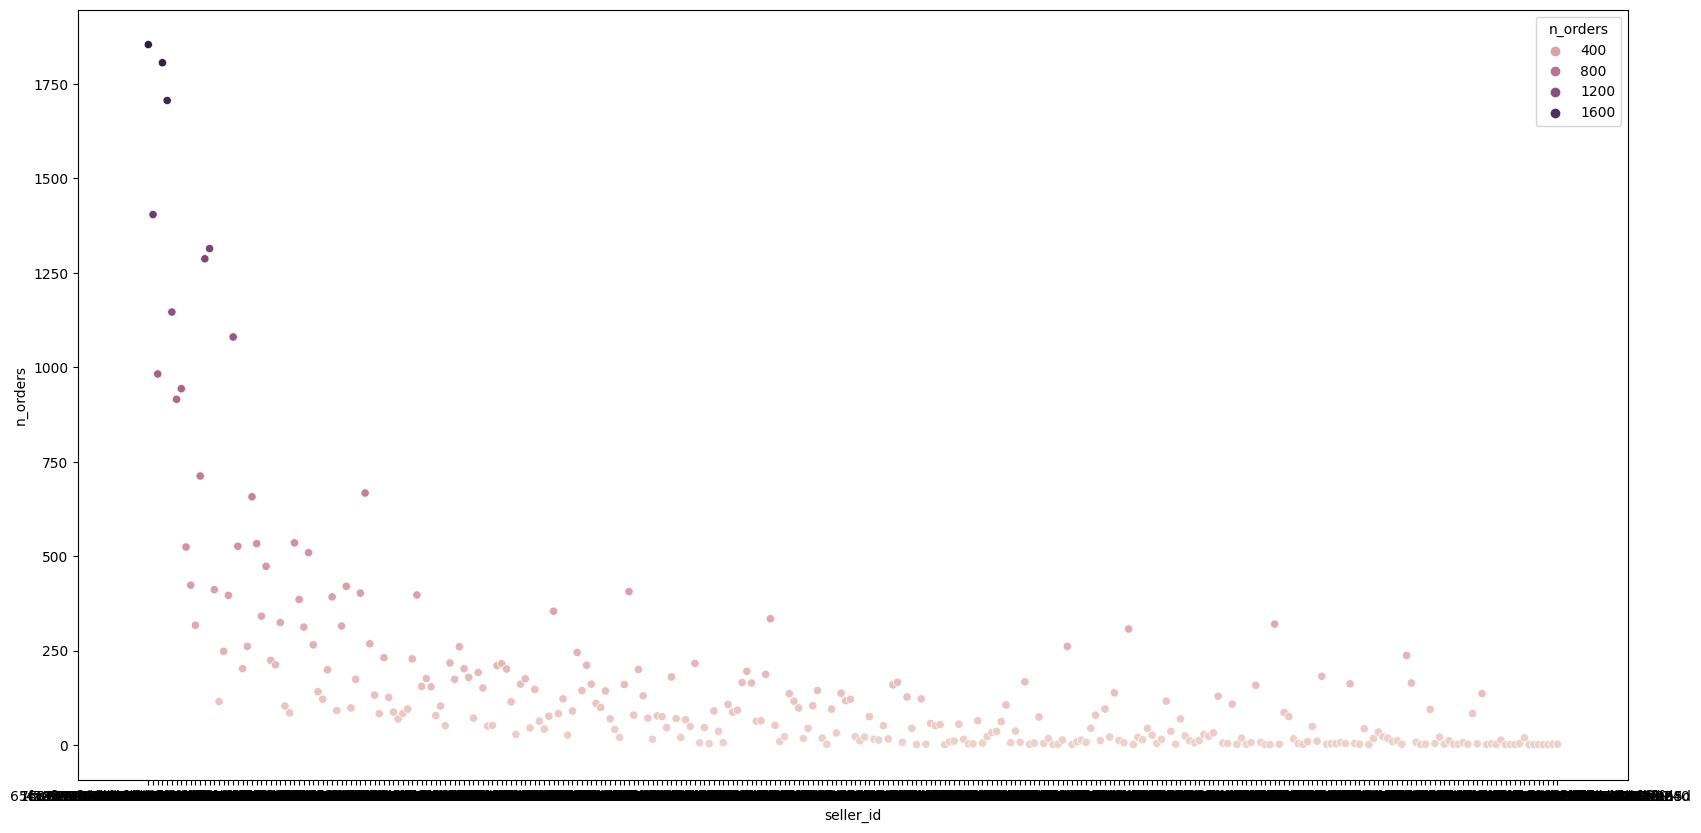

In [246]:
sns.scatterplot(data=impact.head(300), x='seller_id', y='n_orders',hue='n_orders')

Finding: 

Worst sellers have higher order volume.

Order volume impact will be higher at first when removing bad sellers. 

Suggestion :

Start with worst customers and make reassesments along the way. Data will change by time.

### Good luck to the CEO :) End of presentation.